# Load Dataset

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path="/content/drive/MyDrive/Datasets"
import cv2
import pickle
import os

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
import os
# Load dataset
# Define the local path to the downloaded dataset file
data_folder = "/content/drive/MyDrive/My Research/Research_Paper_Skin_Disease/Dataset/"

# Load the dataset
dataset = load_dataset(data_folder)

print(dataset)

Resolving data files:   0%|          | 0/3110 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3110
    })
})


In [ ]:
print(dataset["train"].features['label'].names)

['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


In [ ]:
selected_columns_names = ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
selected_columns = [col for col in dataset["train"].features['label'].names if col in selected_columns_names]
print(selected_columns)

['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


In [ ]:
labels = selected_columns
num_labels = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Actinic keratosis': 0, 'Basal cell carcinoma': 1, 'Benign keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic nevus': 4, 'Melanoma': 5, 'Squamous cell carcinoma': 6, 'Vascular lesion': 7}
{0: 'Actinic keratosis', 1: 'Basal cell carcinoma', 2: 'Benign keratosis', 3: 'Dermatofibroma', 4: 'Melanocytic nevus', 5: 'Melanoma', 6: 'Squamous cell carcinoma', 7: 'Vascular lesion'}


# Forward Pass ViT Model

In [ ]:
import torch
import torch.nn as nn

# Create skin image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768 #or emb_dimension
patch_size = 16

# Conv 2D layer
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size,
             stride=patch_size)

# Forward pass skin img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [ ]:
# Flatten the output after projection with Conv2D layer

patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


In [ ]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 10, 768])


In [ ]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [ ]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=hidden_size, nhead=num_heads,
           dim_feedforward=int(hidden_size * 4),
           dropout=0.1)
transformer_encoder = nn.TransformerEncoder(
           encoder_layer=transformer_encoder_layer,
           num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
!pip install transformers

from transformers import ViTModel

# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1087, -0.2326,  0.0454,  ...,  0.2287,  0.0680, -0.3177],
         [ 0.3406, -0.0677,  0.0158,  ..., -0.1174,  0.1448, -0.2402],
         [ 0.0348, -0.2707, -0.0704,  ...,  0.1475,  0.1170, -0.3218],
         ...,
         [ 0.0213, -0.2589, -0.0813,  ...,  0.0531,  0.2414, -0.3325],
         [ 0.1125, -0.2219, -0.0243,  ...,  0.0907,  0.1610, -0.2229],
         [ 0.1509, -0.1710, -0.0303,  ...,  0.0333,  0.1012, -0.1170]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


In [ ]:
num_labels = 8

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels)

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 8])


# Fine Tuning ViT Impelementation

In [ ]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [ ]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):

      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)

  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])

  def get_labels(self, idx):
      return self.input_data[idx]['label']

  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

In [ ]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output

In [ ]:
# def model_train(dataset, epochs, learning_rate, bs):

#     use_cuda = torch.cuda.is_available()
#     device = torch.device("cuda" if use_cuda else "cpu")

#     # Load nodel, loss function, and optimizer
#     model = ViT().to(device)
#     criterion = nn.CrossEntropyLoss().to(device)
#     optimizer = Adam(model.parameters(), lr=learning_rate)

#     # Load batch image
#     train_dataset = ImageDataset(dataset)
#     train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)

#     # Fine tuning loop
#     for i in range(epochs):
#         total_acc_train = 0
#         total_loss_train = 0.0

#         for train_image, train_label in tqdm(train_dataloader):
#             output = model(train_image.to(device))
#             loss = criterion(output, train_label.to(device))
#             acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
#             total_acc_train += acc
#             total_loss_train += loss.item()

#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#         print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

#     return model

# # Hyperparameters
# EPOCHS = 10
# LEARNING_RATE = 1e-4
# BATCH_SIZE = 8

# # Train the model
# trained_model = model_train(dataset['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 389/389 [23:45<00:00,  3.66s/it]


Epoch 1/20 | Loss: 0.194 | Accuracy: 0.528


100%|██████████| 389/389 [02:22<00:00,  2.74it/s]


Epoch 2/20 | Loss: 0.106 | Accuracy: 0.734


100%|██████████| 389/389 [02:21<00:00,  2.74it/s]


Epoch 3/20 | Loss: 0.059 | Accuracy: 0.860


100%|██████████| 389/389 [02:19<00:00,  2.78it/s]


Epoch 4/20 | Loss: 0.028 | Accuracy: 0.943


100%|██████████| 389/389 [02:24<00:00,  2.70it/s]


Epoch 5/20 | Loss: 0.023 | Accuracy: 0.947


100%|██████████| 389/389 [02:23<00:00,  2.72it/s]


Epoch 6/20 | Loss: 0.014 | Accuracy: 0.964


100%|██████████| 389/389 [02:24<00:00,  2.70it/s]


Epoch 7/20 | Loss: 0.006 | Accuracy: 0.987


100%|██████████| 389/389 [02:22<00:00,  2.72it/s]


Epoch 8/20 | Loss: 0.010 | Accuracy: 0.980


100%|██████████| 389/389 [02:25<00:00,  2.68it/s]


Epoch 9/20 | Loss: 0.014 | Accuracy: 0.967


100%|██████████| 389/389 [02:32<00:00,  2.56it/s]


Epoch 10/20 | Loss: 0.006 | Accuracy: 0.987


100%|██████████| 389/389 [02:23<00:00,  2.72it/s]


Epoch 11/20 | Loss: 0.003 | Accuracy: 0.994


100%|██████████| 389/389 [02:26<00:00,  2.66it/s]


Epoch 12/20 | Loss: 0.010 | Accuracy: 0.980


100%|██████████| 389/389 [02:23<00:00,  2.71it/s]


Epoch 13/20 | Loss: 0.005 | Accuracy: 0.989


100%|██████████| 389/389 [02:22<00:00,  2.73it/s]


Epoch 14/20 | Loss: 0.006 | Accuracy: 0.989


100%|██████████| 389/389 [02:22<00:00,  2.73it/s]


Epoch 15/20 | Loss: 0.007 | Accuracy: 0.983


100%|██████████| 389/389 [02:24<00:00,  2.70it/s]


Epoch 16/20 | Loss: 0.004 | Accuracy: 0.991


100%|██████████| 389/389 [02:22<00:00,  2.74it/s]


Epoch 17/20 | Loss: 0.001 | Accuracy: 0.999


100%|██████████| 389/389 [02:23<00:00,  2.71it/s]


Epoch 18/20 | Loss: 0.005 | Accuracy: 0.988


100%|██████████| 389/389 [02:30<00:00,  2.59it/s]


Epoch 19/20 | Loss: 0.012 | Accuracy: 0.971


100%|██████████| 389/389 [02:22<00:00,  2.73it/s]


Epoch 20/20 | Loss: 0.002 | Accuracy: 0.995


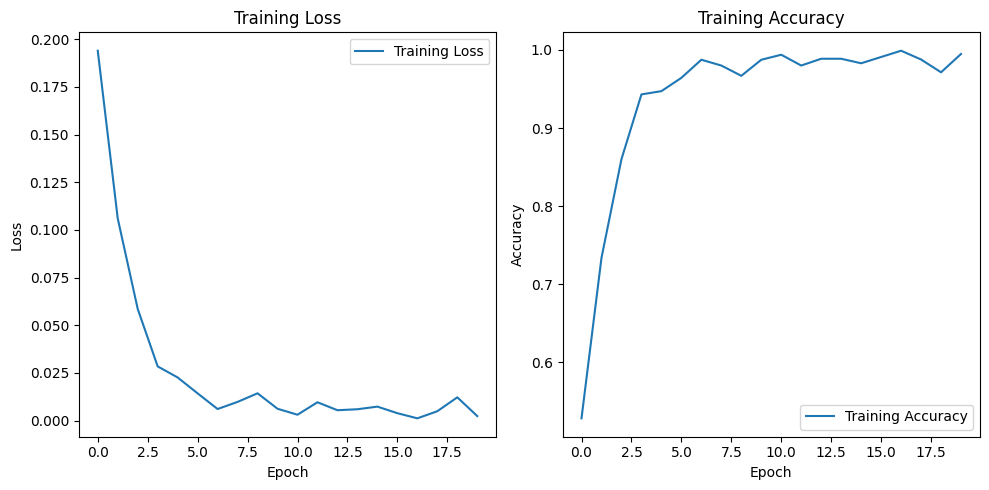

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load model, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Lists to store accuracy and loss for plotting
    train_loss_list = []
    train_acc_list = []

    feature_map_layer = 'last_hidden_state'

    # Fine-tuning loop
    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        model.train()  # Set the model to training mode

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))



            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Calculate and store average loss and accuracy for the epoch
        avg_loss_train = total_loss_train / len(train_dataset)
        avg_acc_train = total_acc_train / len(train_dataset)
        train_loss_list.append(avg_loss_train)
        train_acc_list.append(avg_acc_train)

        # Print and store results
        print(f'Epoch {epoch + 1}/{epochs} | Loss: {avg_loss_train:.3f} | Accuracy: {avg_acc_train:.3f}')

    # Plotting training curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Hyperparameters
EPOCHS = 20
LEARNING_RATE = 1e-4/2
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

# Model Prediction

In [ ]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return prediction

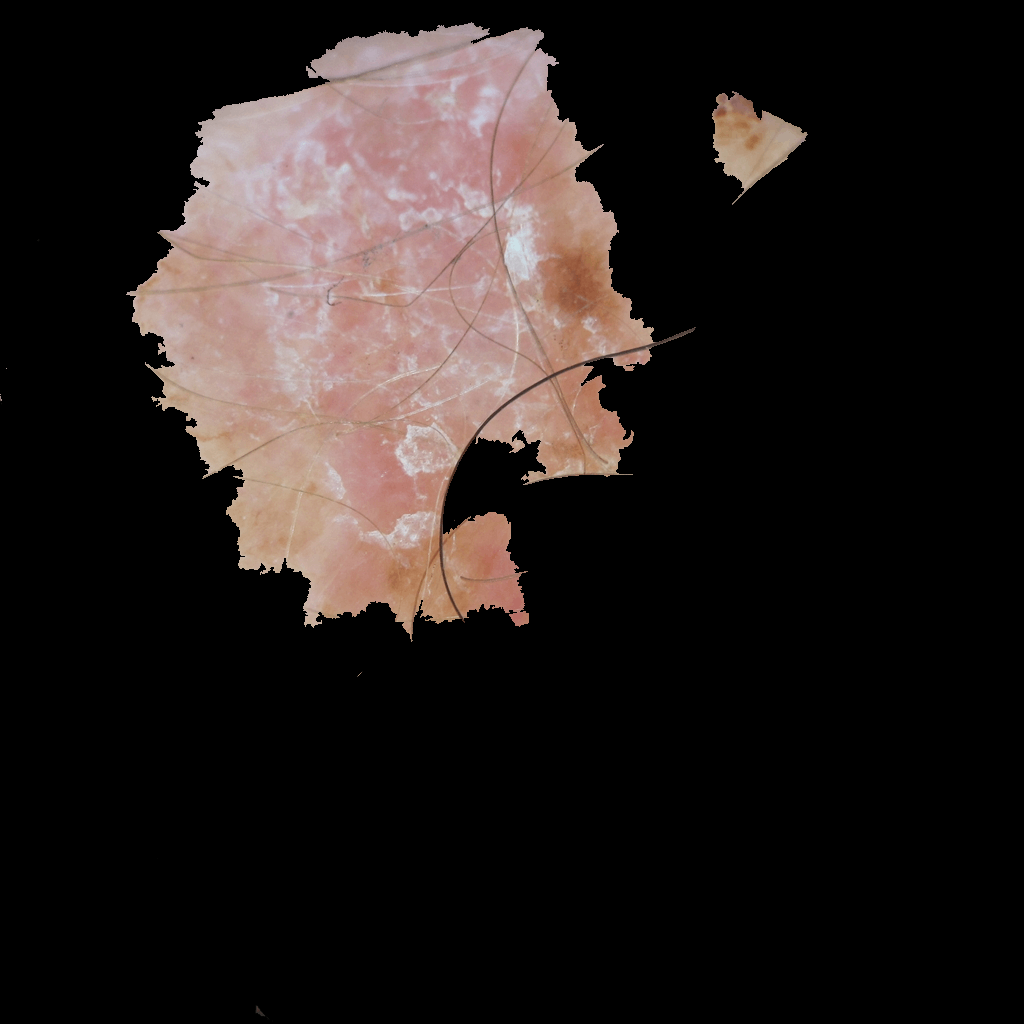

In [ ]:
dataset['train'][1]['image']

In [ ]:
print(predict(dataset['train'][1]['image']))

0


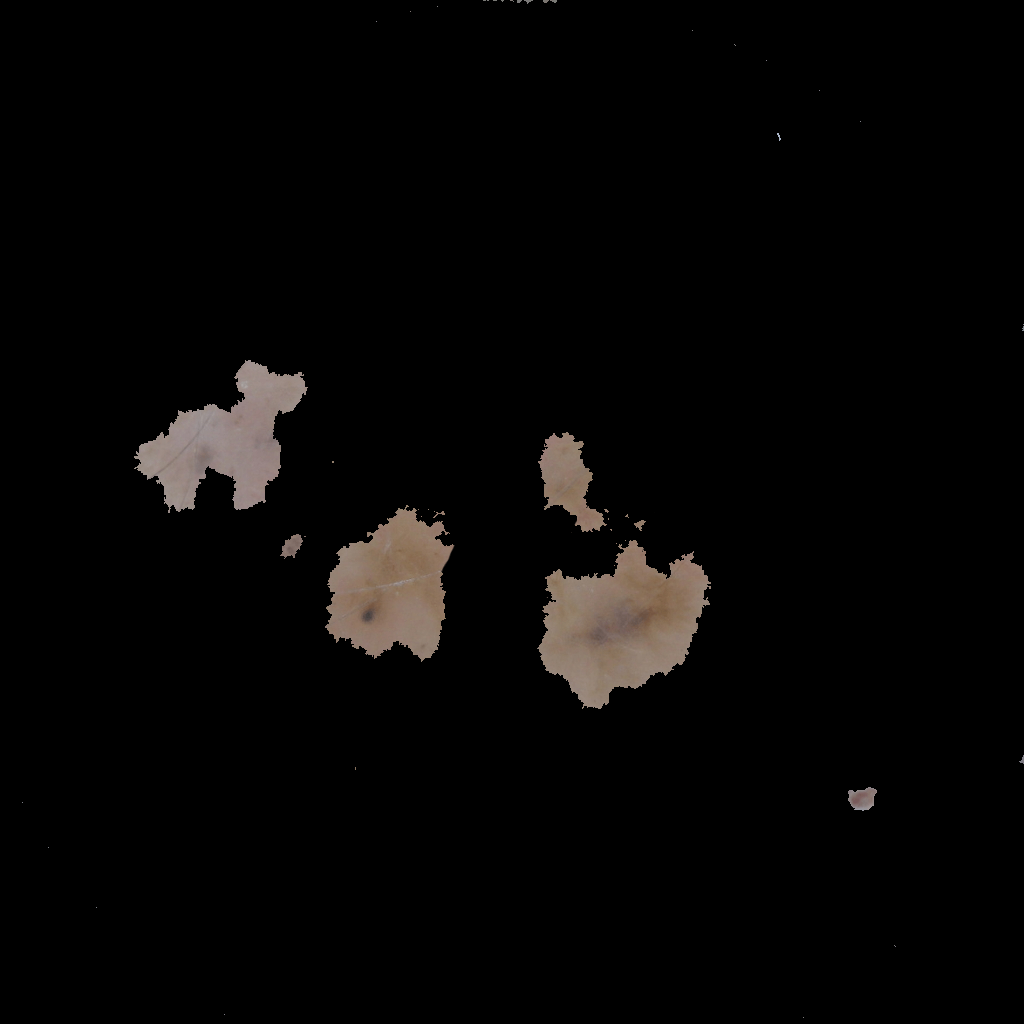

In [ ]:
dataset['train'][452]['image']

In [ ]:
print(predict(dataset['train'][452]['image']))

2


Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        85
           2       1.00      1.00      1.00        77
           3       1.00      1.00      1.00        39
           4       1.00      1.00      1.00        90
           5       1.00      1.00      1.00        79
           6       1.00      1.00      1.00        94
           7       1.00      1.00      1.00        43

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



<Figure size 800x600 with 0 Axes>

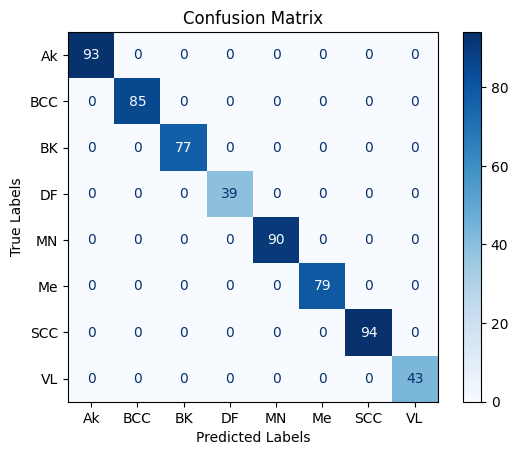

In [ ]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

all_predictions = []
all_labels = []

for i in range(600):
  rand = (random.randint(0,3107))
  all_predictions.append(dataset['train'][rand]['label'])
  all_labels.append(predict(dataset['train'][rand]['image']))

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')



print(classification_report(all_predictions, all_labels))

confusion = confusion_matrix(all_predictions, all_labels)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['Ak', 'BCC', 'BK', 'DF', 'MN', 'Me', 'SCC', 'VL'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
